In [1]:
import torch

from models.normalizing_flow import HierarchicalNormalizingFlow

from models.planar import planar
import matplotlib.pyplot as plt
import os
import numpy as np
import wandb

torch.set_grad_enabled(False)


In [2]:
run_ids = [
"10xapuoj",
"momsyrpu",
"ibughq28",
"3sv9s9rc",
"3dc3rk14",
"271tpimr",
"1uh04c61",
"1sva9hwk",
"1dg3asfv",
"17gf023x",
"16ngk6j2",
"r2132oze",
"q3t73hlt",
"hmx3zjfr",
"3igy48cc",
"3f3l9m8p",
"2zw00lcd",
"2zqbh9dh",
"2n0ams69",
"thvjg2xx",
"9y2x368d",
"26ceae41",
"22y5c8z7",
"1t110x53",
"1keghpu2",
]

In [3]:
run_id = run_ids[0]

In [4]:
api = wandb.Api()

In [5]:
run = api.run(f"druhe/gw-src/{run_id}")

In [6]:
import tempfile

In [7]:
dim = 2
probabilities = {d: {} for d in range(dim)}

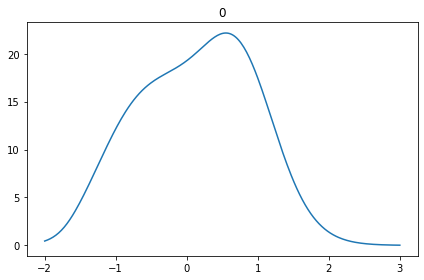

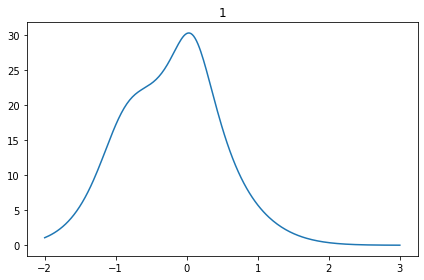

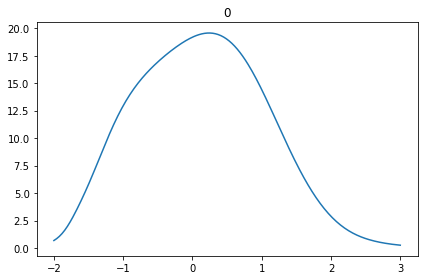

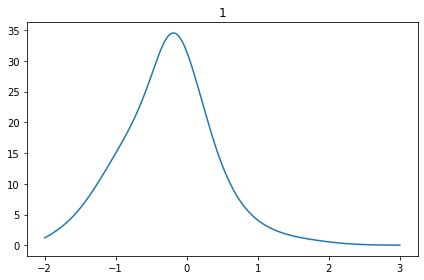

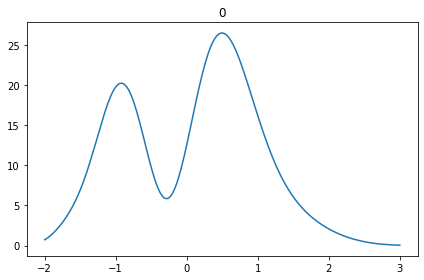

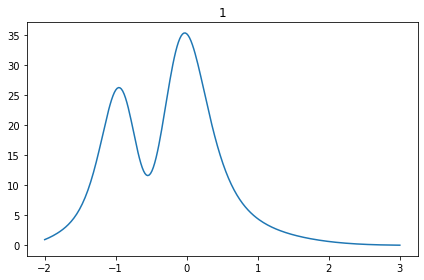

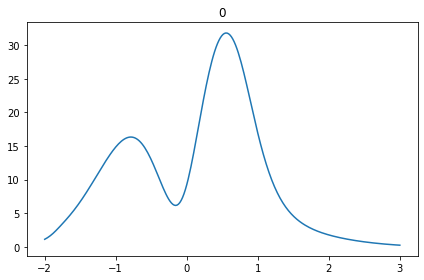

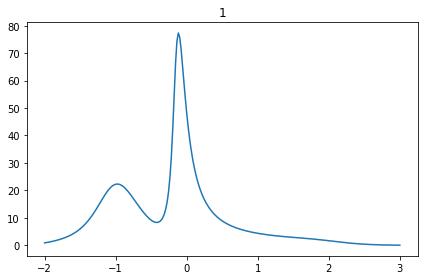

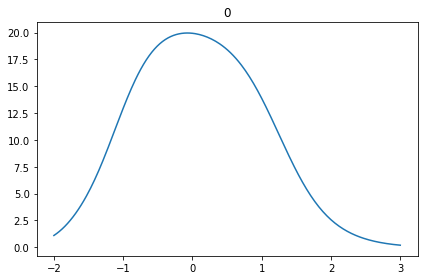

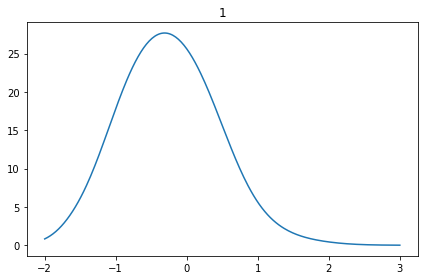

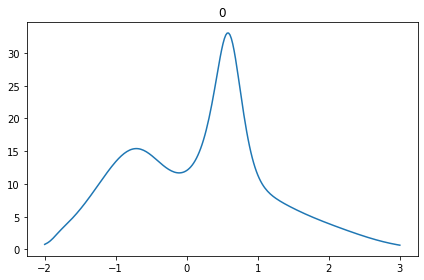

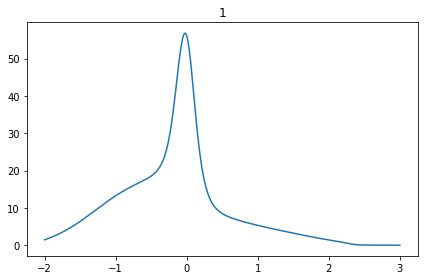

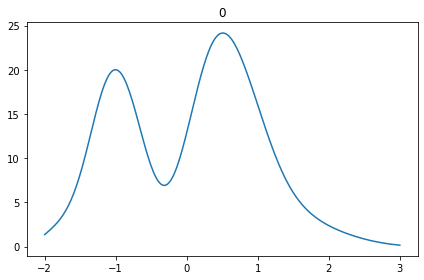

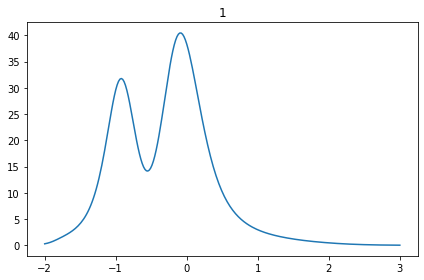

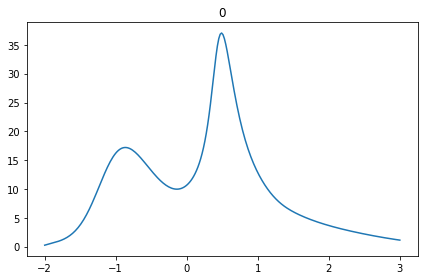

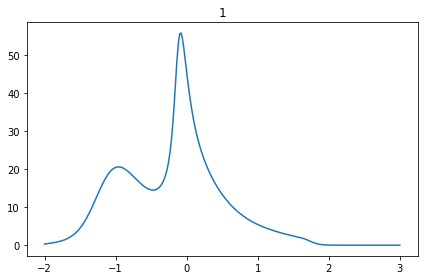

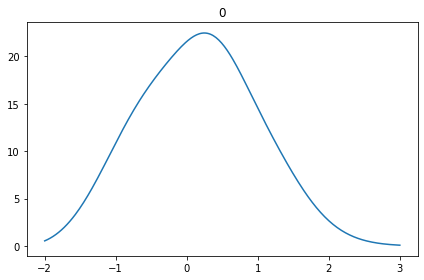

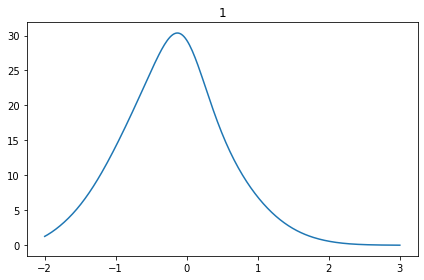

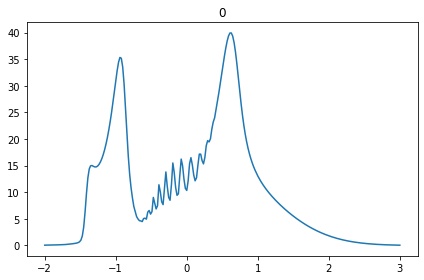

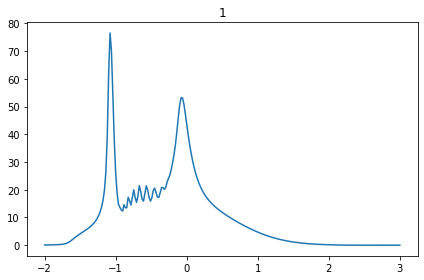

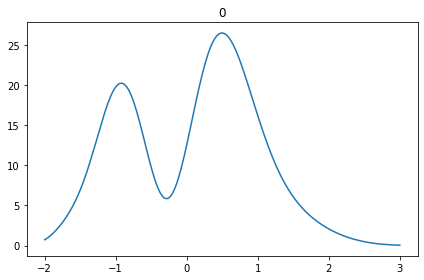

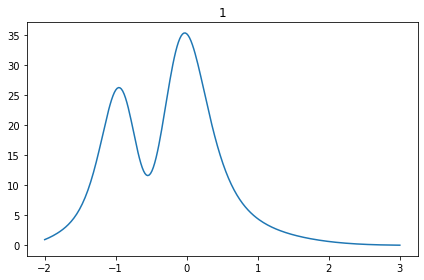

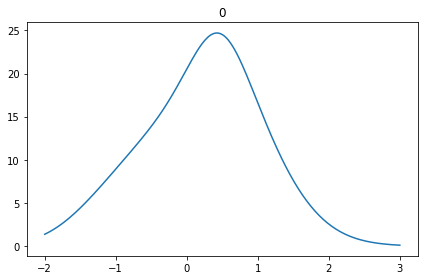

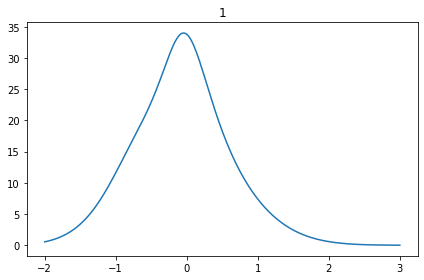

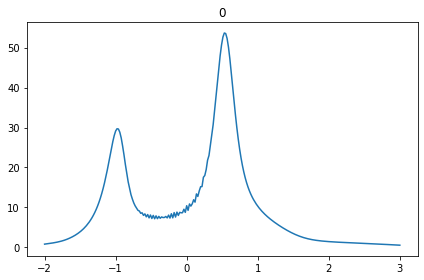

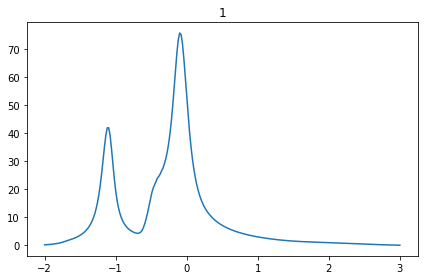

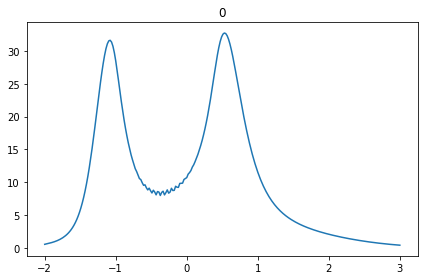

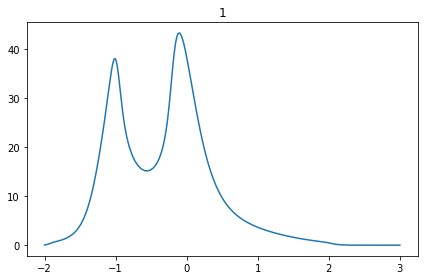

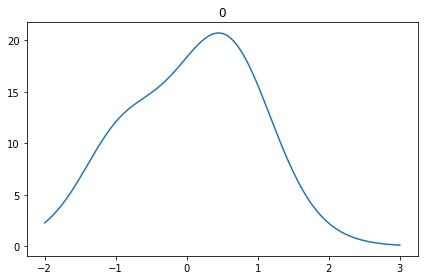

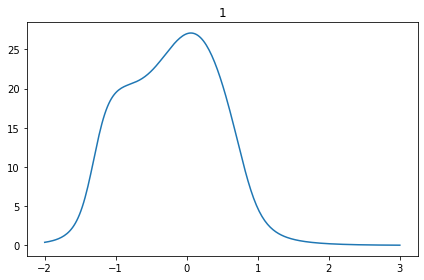

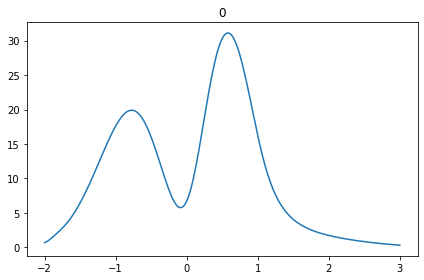

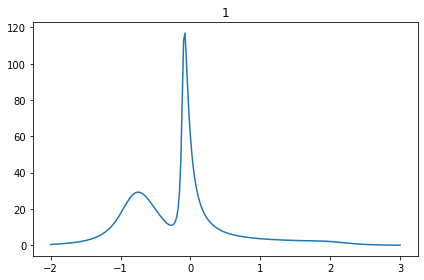

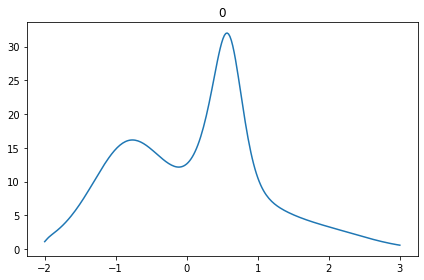

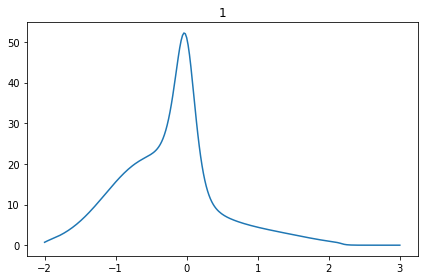

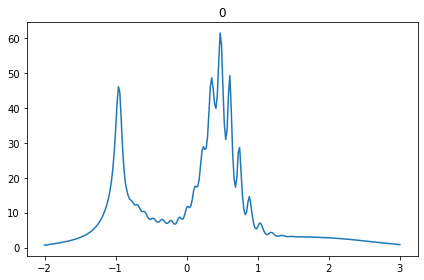

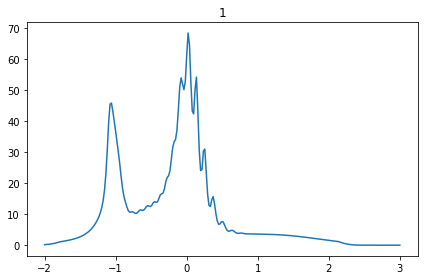

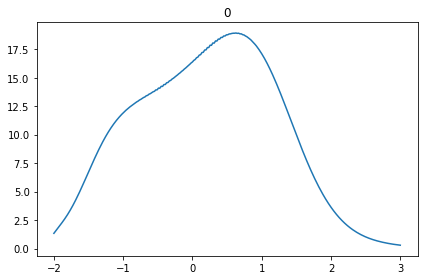

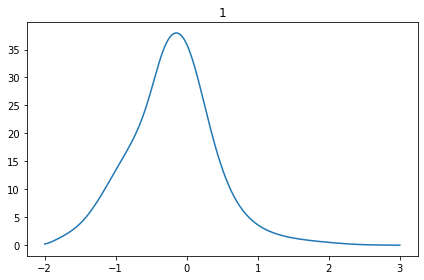

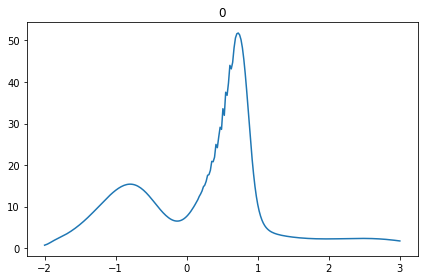

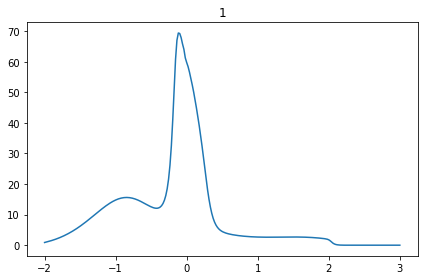

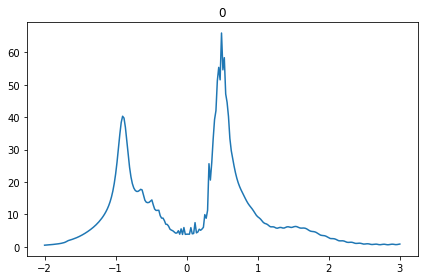

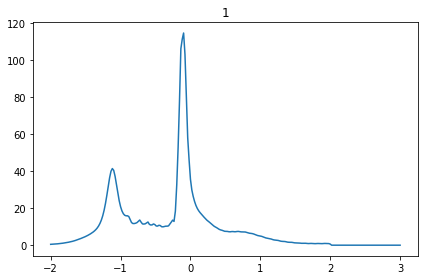

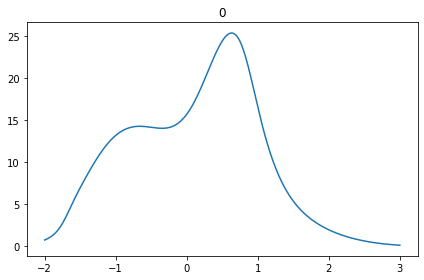

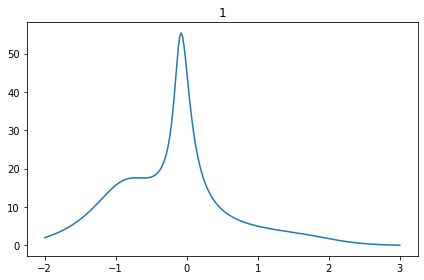

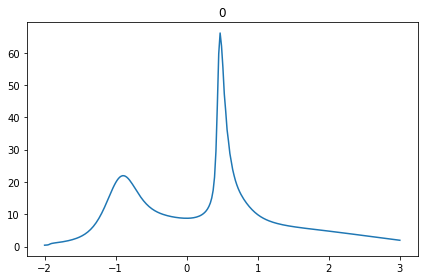

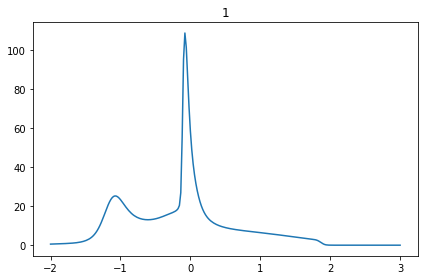

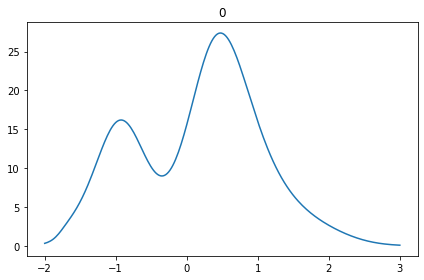

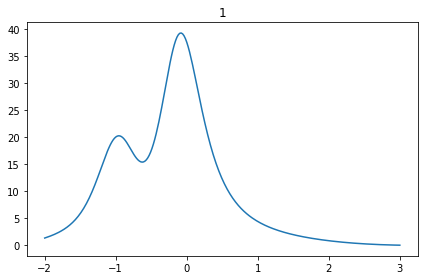

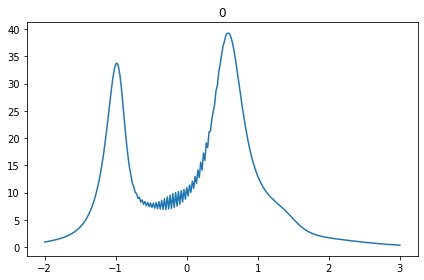

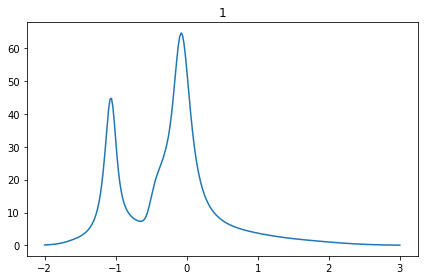

In [8]:
with tempfile.TemporaryDirectory() as tempdir:
    paths = []
    
    for run_id in run_ids:
        run = api.run(f"druhe/gw-src/{run_id}")
        for f in run.files():
            if f.name.endswith('.ckpt'):
                f.download(tempdir, replace=True)
                paths.append(os.path.join(tempdir, f.name))
        

    for model_path in paths:
        flows = planar(input_dim=dim, num_layers=8)
        model = HierarchicalNormalizingFlow.load_from_checkpoint(model_path, flows=flows)
        boundaries = (-2, 3)
        resolution = 256
        normalize = False
        keys = None

        grid = torch.linspace(*boundaries, resolution)
        d_grid = [grid] * dim
        meshgrid = torch.meshgrid(*d_grid, indexing="xy")
        x = torch.stack(meshgrid).reshape(dim, -1).permute(1, 0)
        shape = [resolution] * dim
        
        prob = model.log_prob(x).exp().view(*shape)
        if 'joint' not in probabilities:
            probabilities['joint'] = []
        
        probabilities['joint'].append(prob)
        
#         plt.imshow(prob, origin='lower')
#         plt.show()
        d_grid = torch.stack(d_grid, dim=-1)
        for d in range(dim):

            if keys is not None:
                key = keys[d]
            else:
                key = d
                
            
            
            dimensions_to_sum = list(range(dim))
            dimensions_to_sum.pop(d)

            if len(dimensions_to_sum) == 0:
                marginal = prob
            else:
                marginal = prob.sum(dim=tuple(dimensions_to_sum))

            plt.plot(d_grid[:, d].numpy(), marginal.numpy())
            plt.title(key)
            plt.tight_layout()
            plt.show()
            plt.close()


            probabilities[d]['grid'] = d_grid[:, d].numpy()
            if 'p' not in probabilities[d]:
                probabilities[d]['p'] = list()
            probabilities[d]['p'].append(marginal.numpy())
        

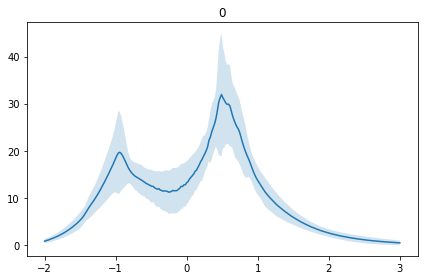

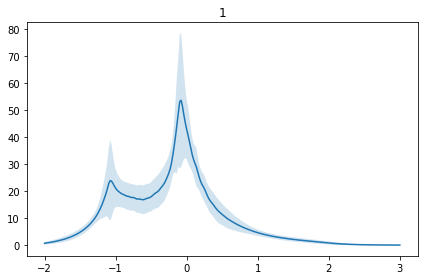

In [9]:
for d in range(dim):
    p_dict = probabilities[d]
    
    grid = p_dict['grid']
    
    p = np.stack(p_dict['p'])
    mean = p.mean(0)
    std = p.std(0)
    plt.plot(grid, mean)
    plt.fill_between(grid, mean - std, mean + std, alpha=0.2)


    plt.title(d)
    plt.tight_layout()
    plt.show()
    plt.close()

In [10]:
from data.m1 import M1Dataset

In [11]:
dataset = M1Dataset('../datasets/Combined_GWTC_m1m2chieffz.npz', split='test')

In [12]:
x = dataset.normalize_inverse(d_grid)

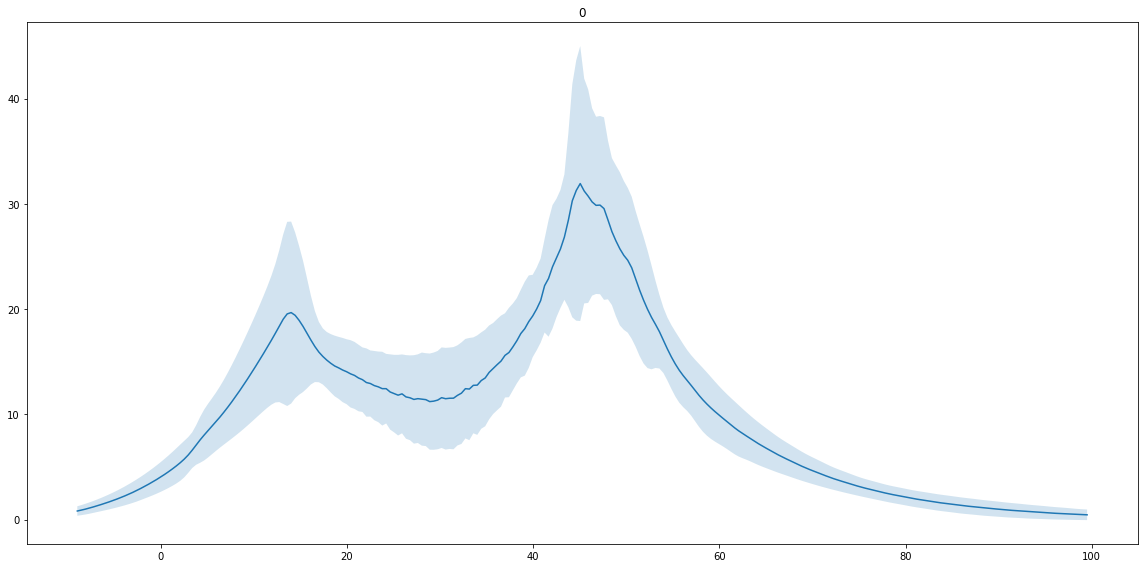

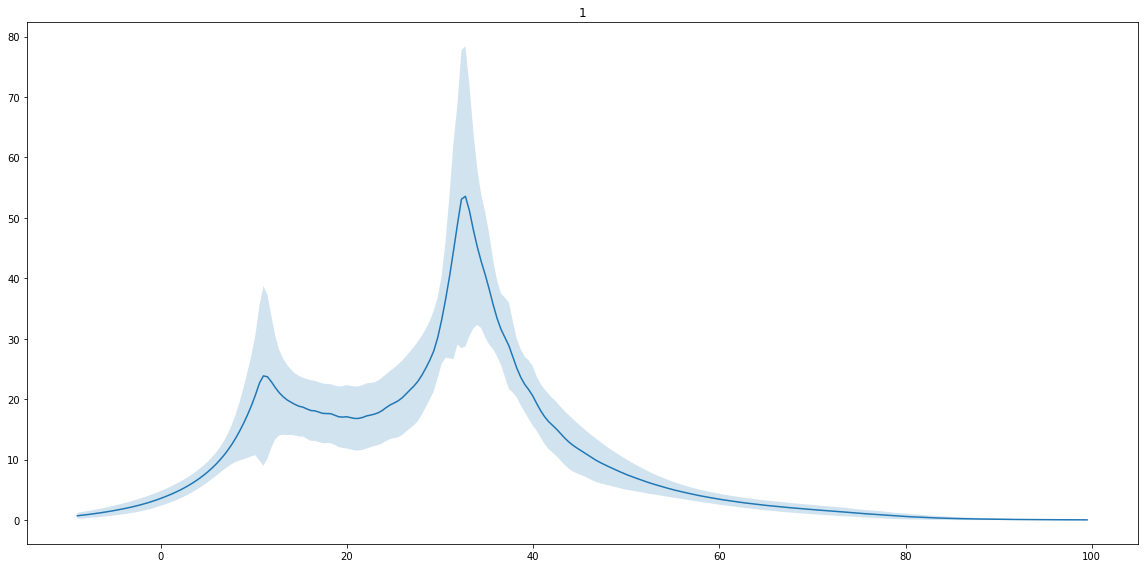

In [13]:
for d in range(dim):
    p_dict = probabilities[d]
    
    grid = x[:, d]
    
    p = np.stack(p_dict['p'])
    mean = p.mean(0)
    std = p.std(0)
    plt.figure(figsize=(16, 8), facecolor='white')

    plt.plot(grid, mean)
    plt.fill_between(grid, mean - std, mean + std, alpha=0.2)


    plt.title(d)
    plt.tight_layout()
    plt.show()
    plt.close()

In [22]:
grid.shape

torch.Size([256])

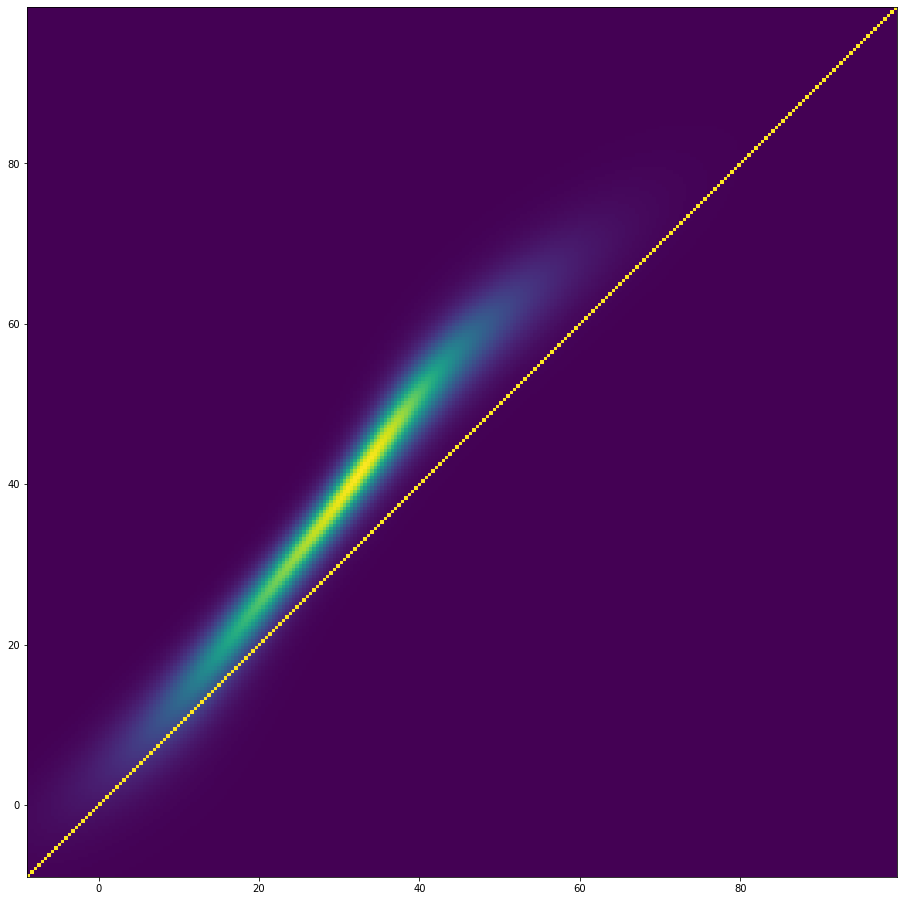

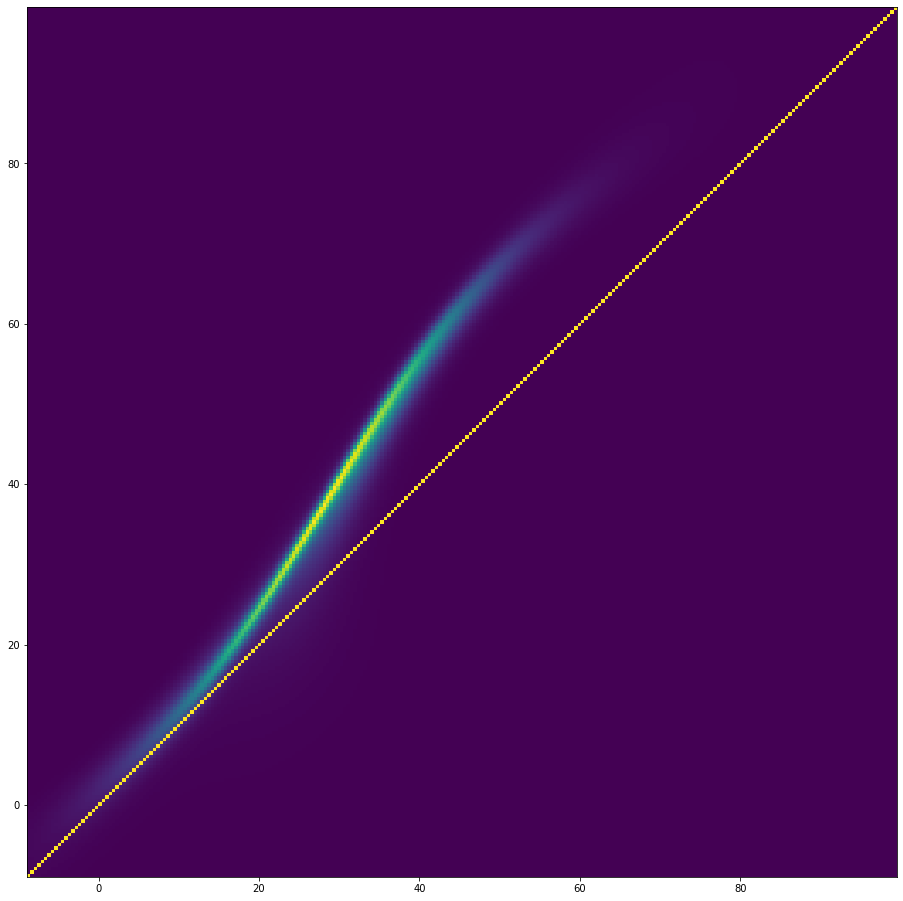

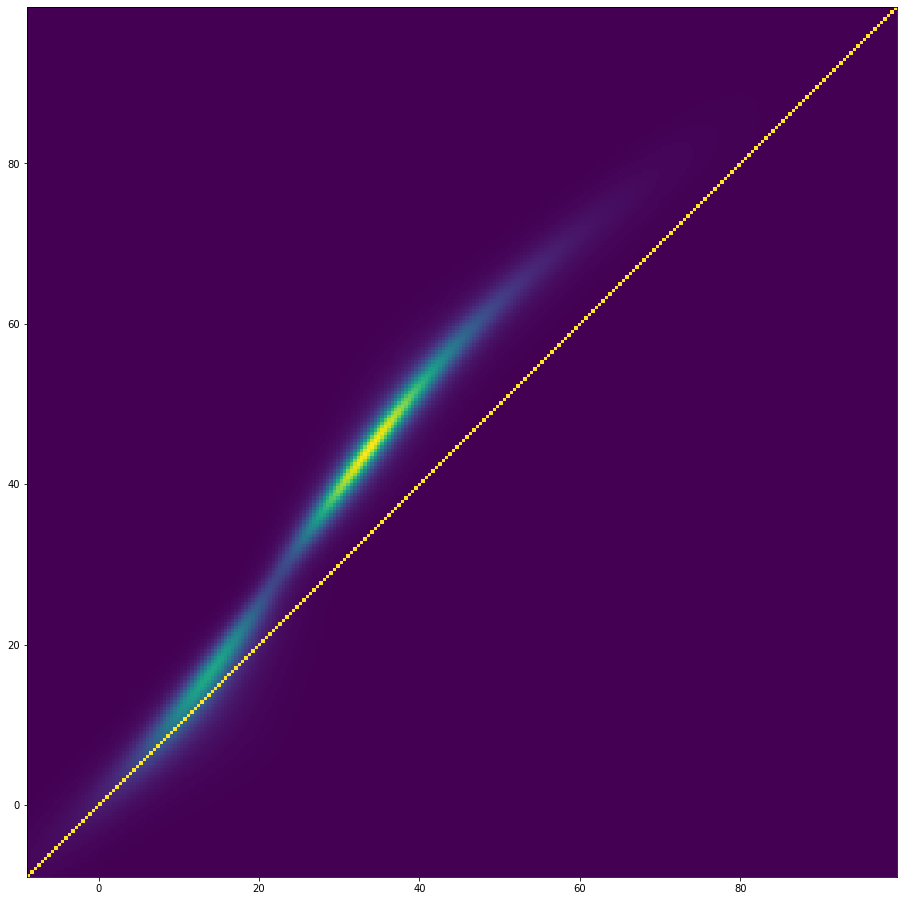

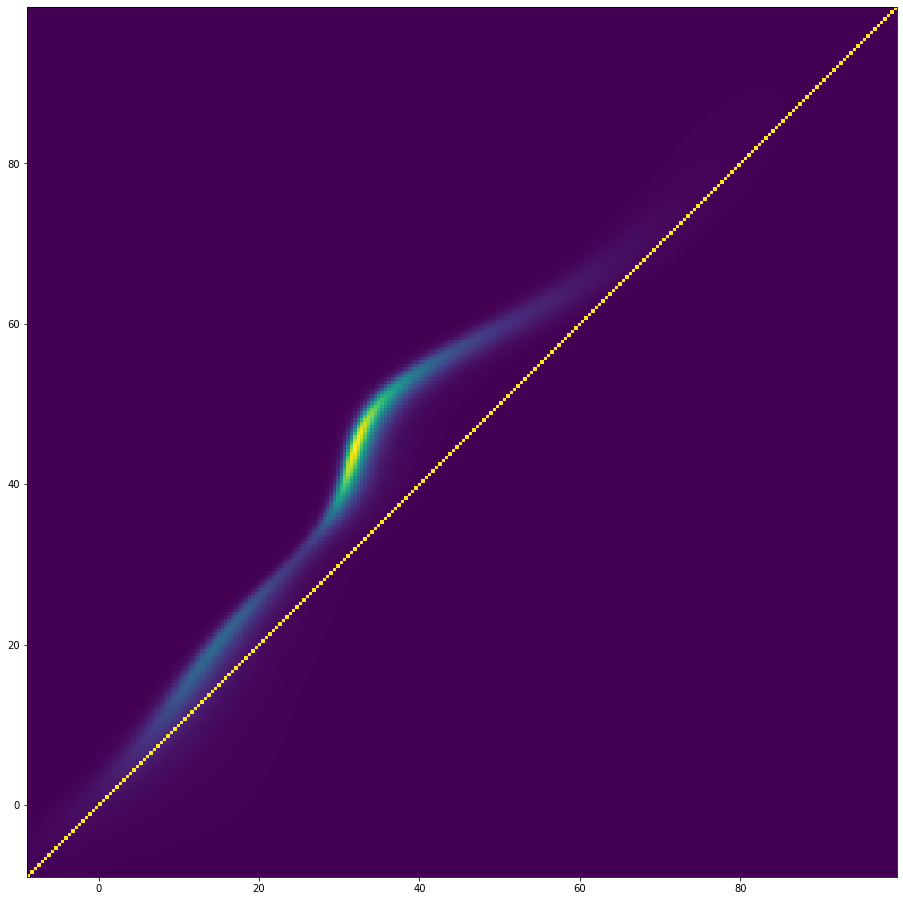

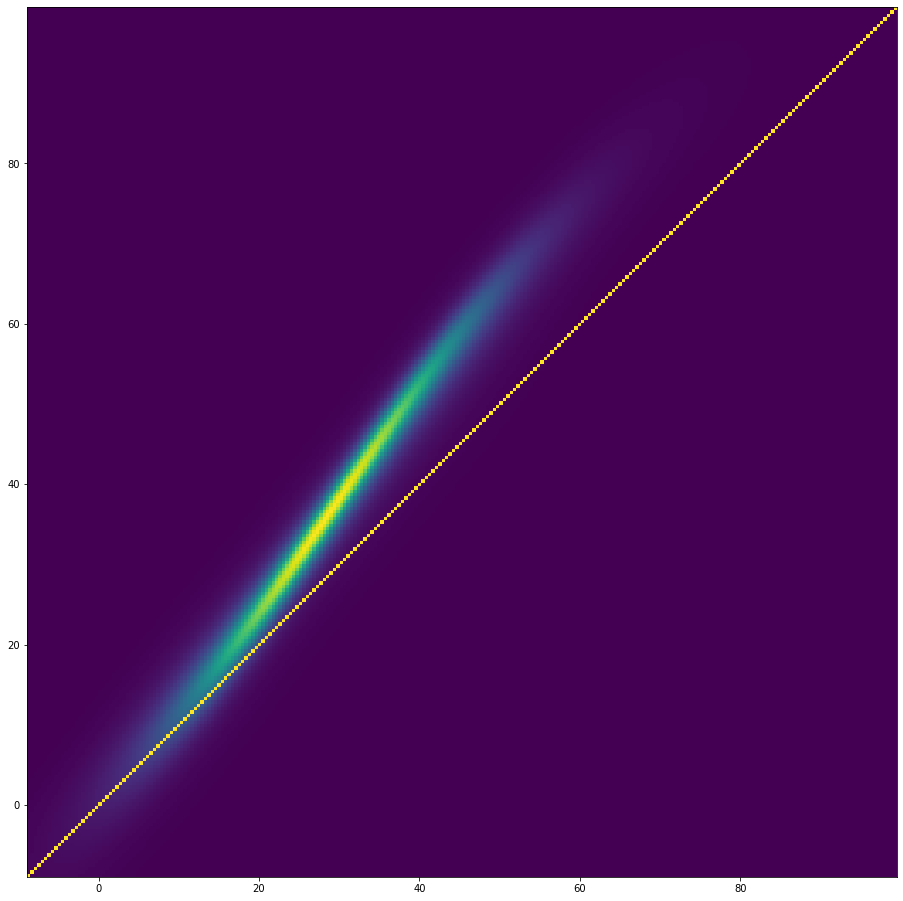

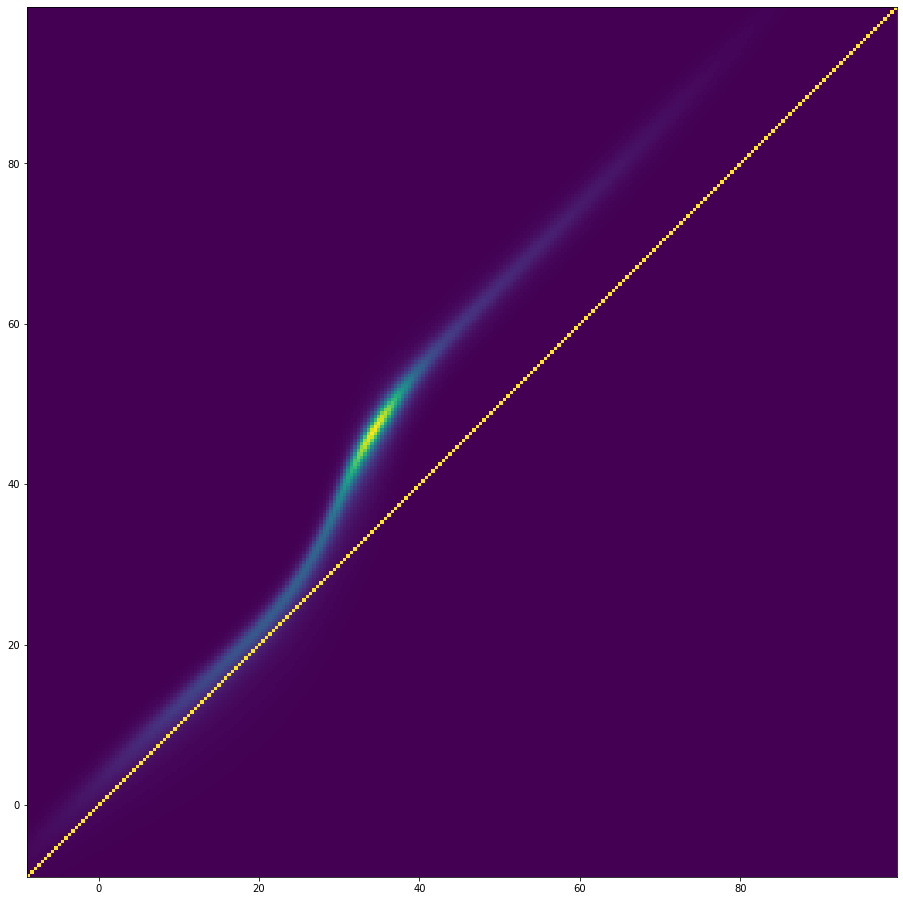

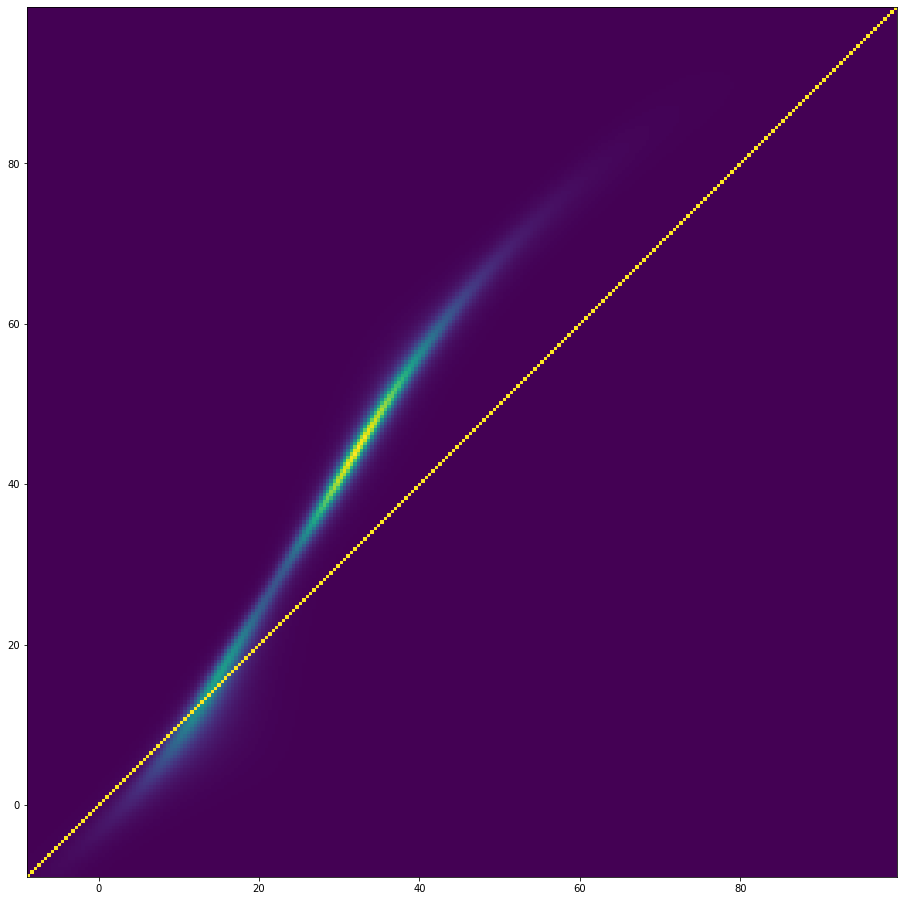

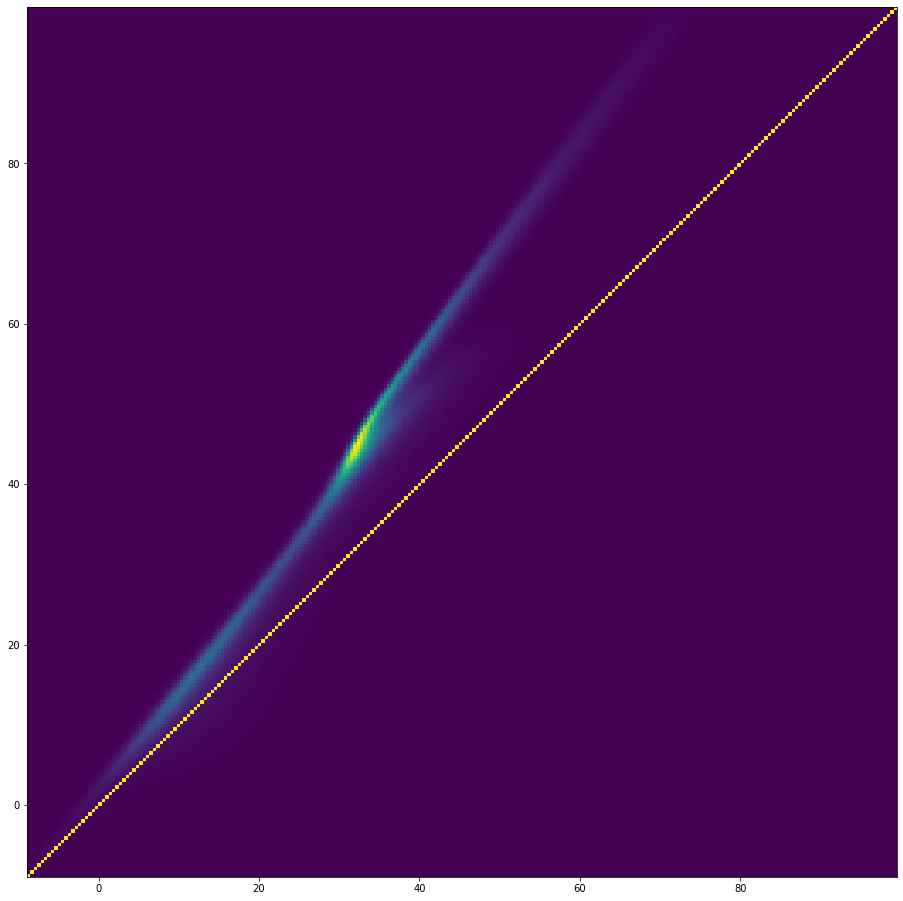

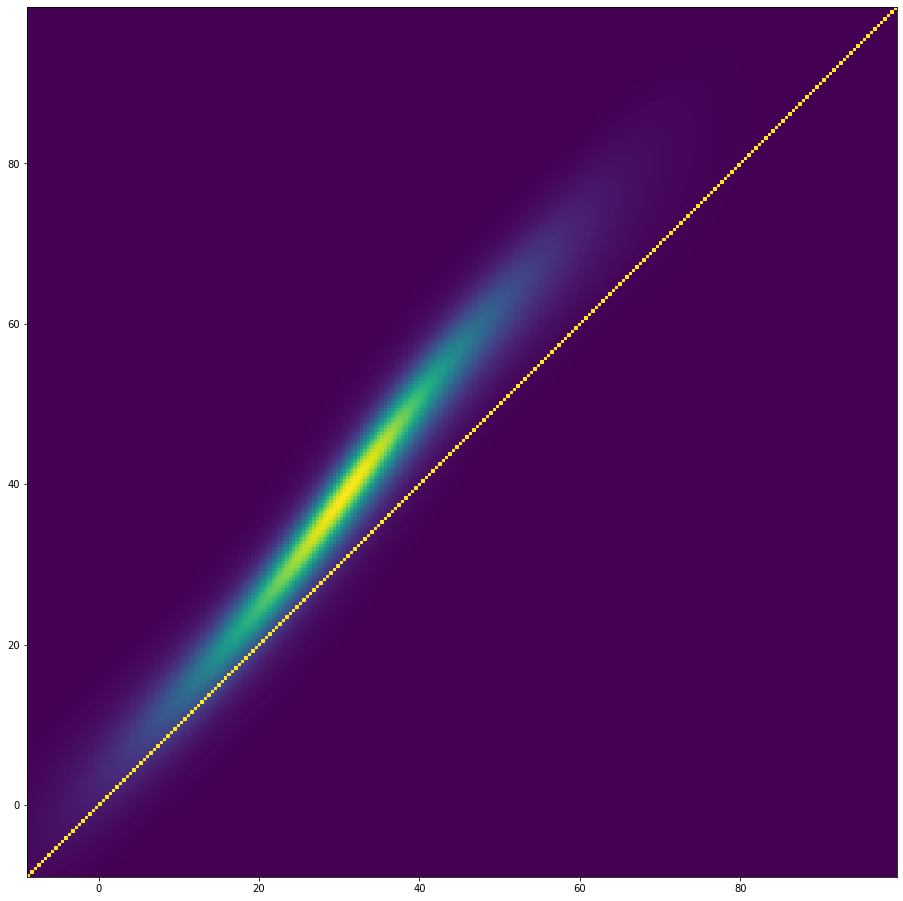

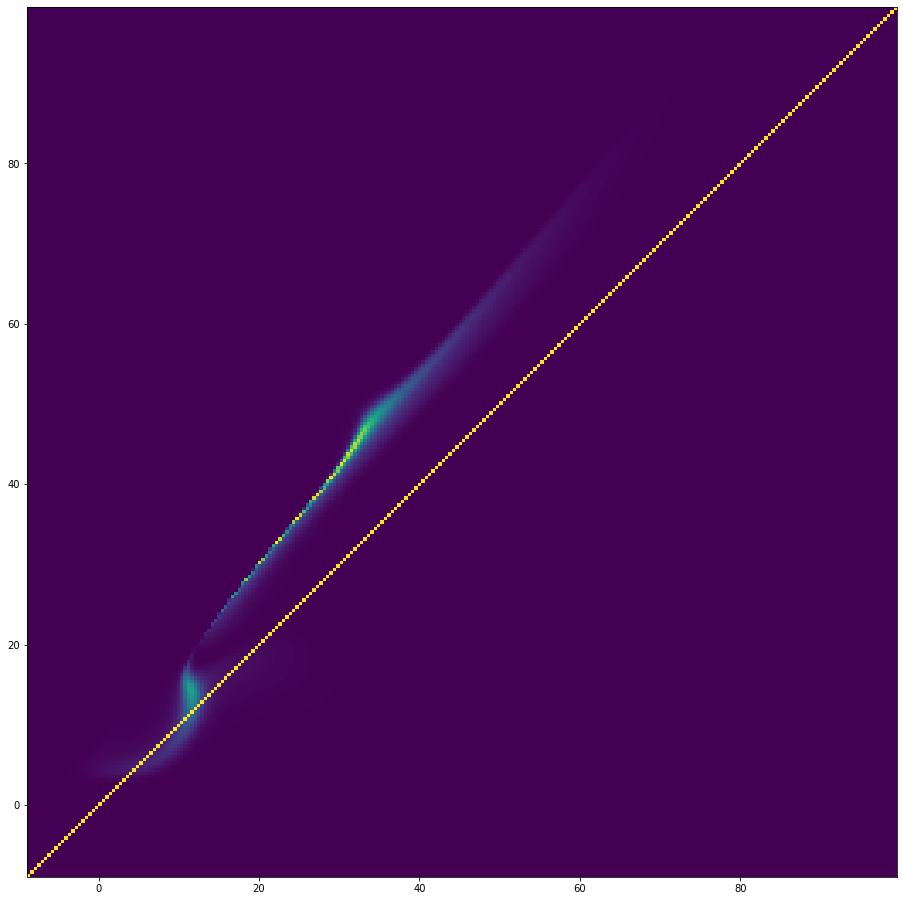

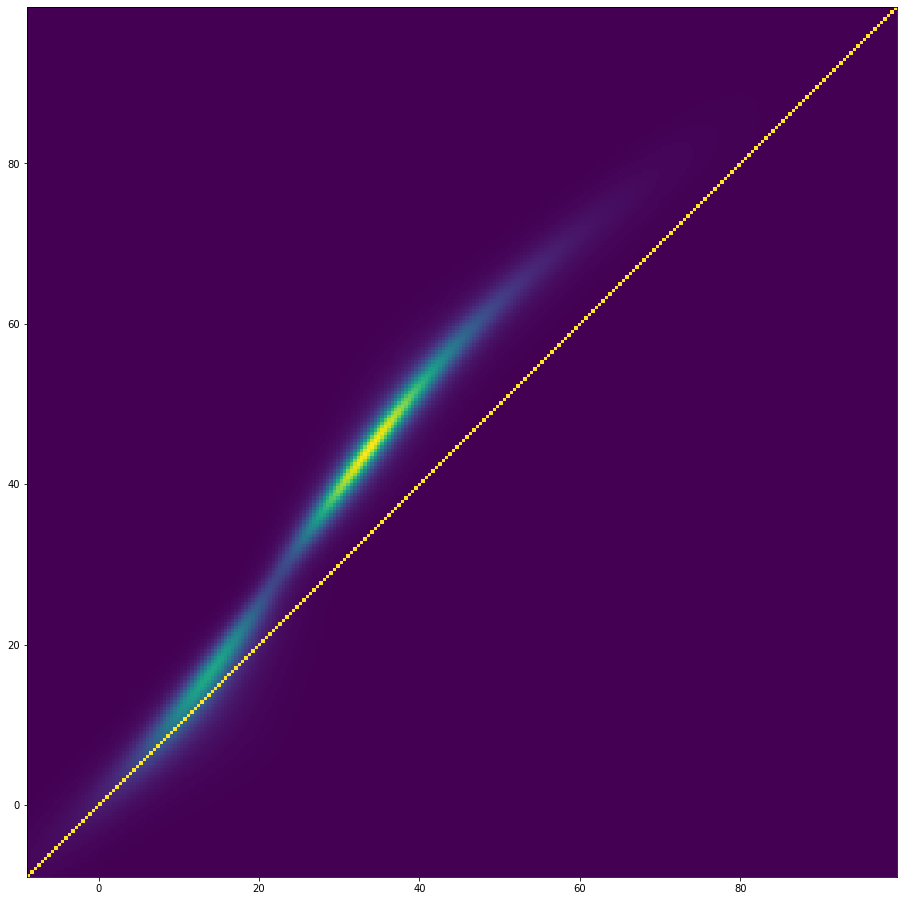

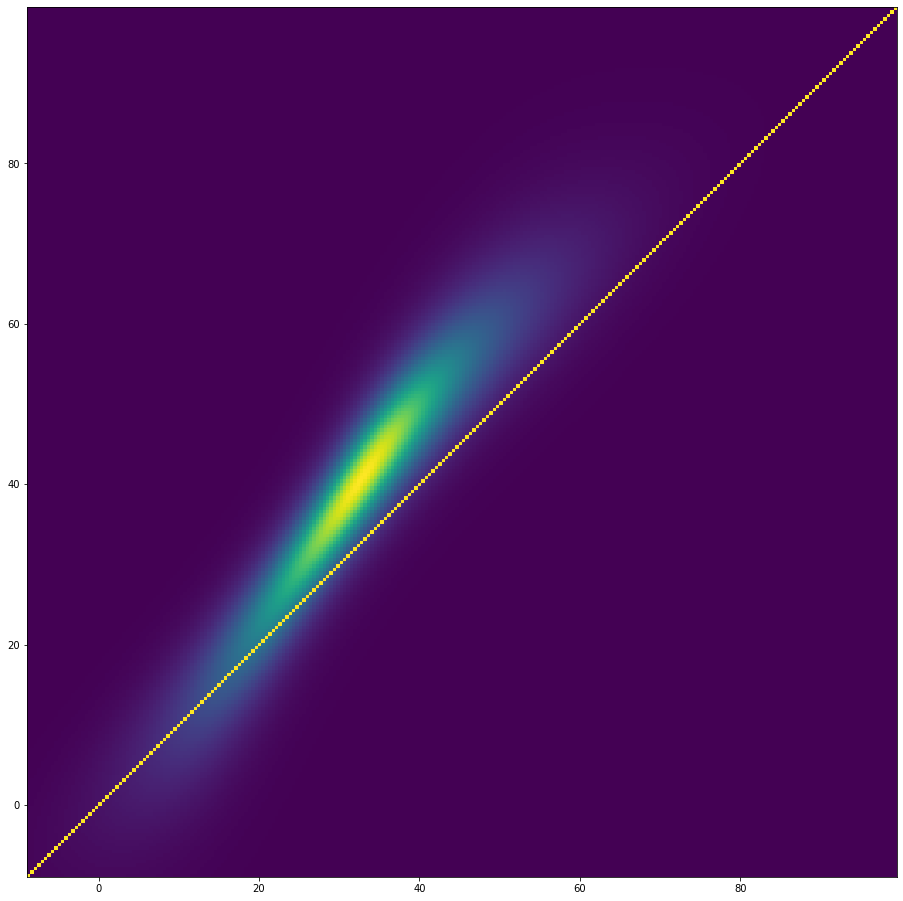

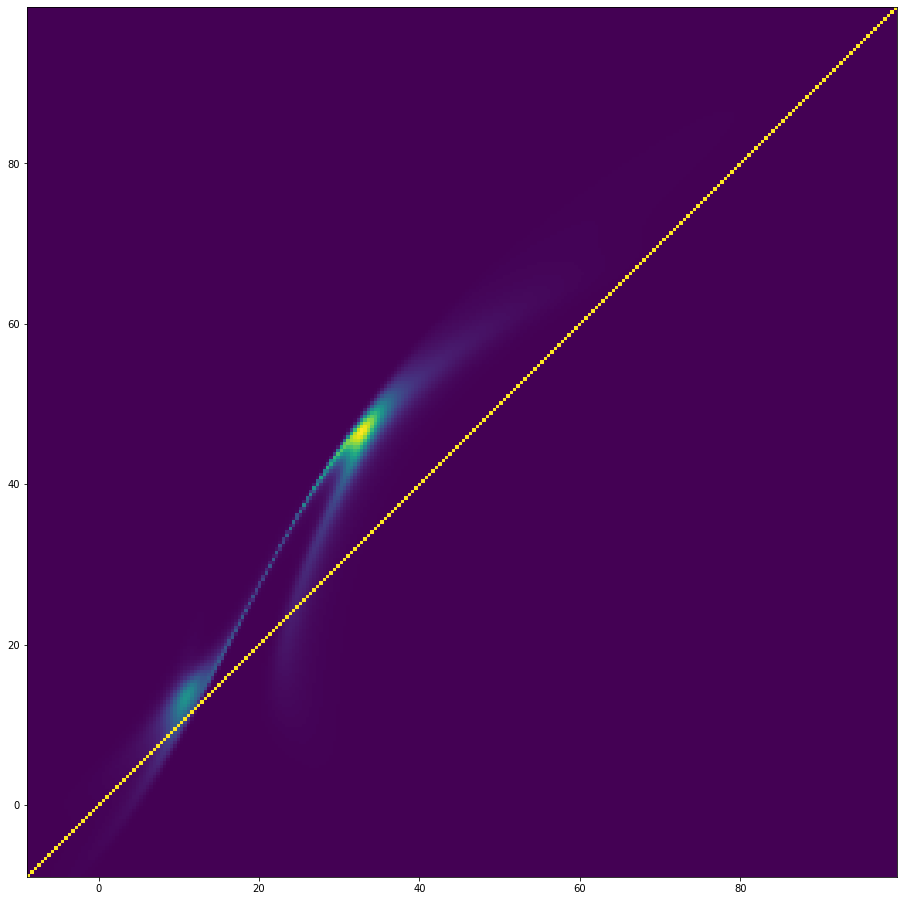

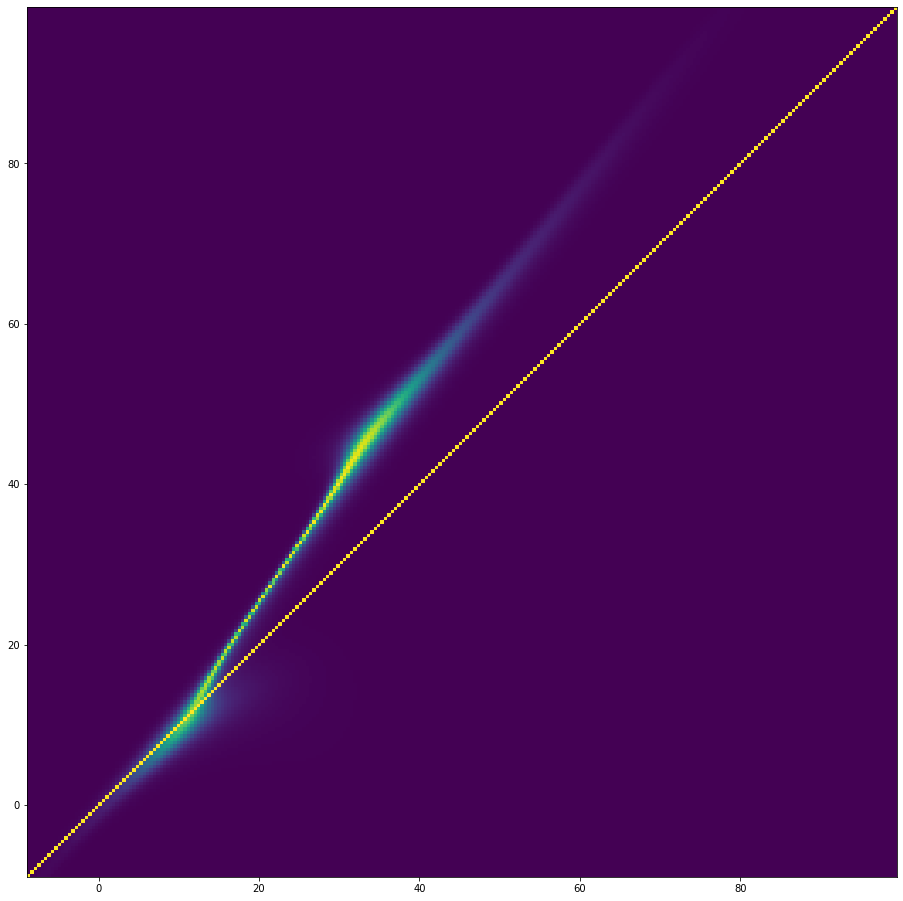

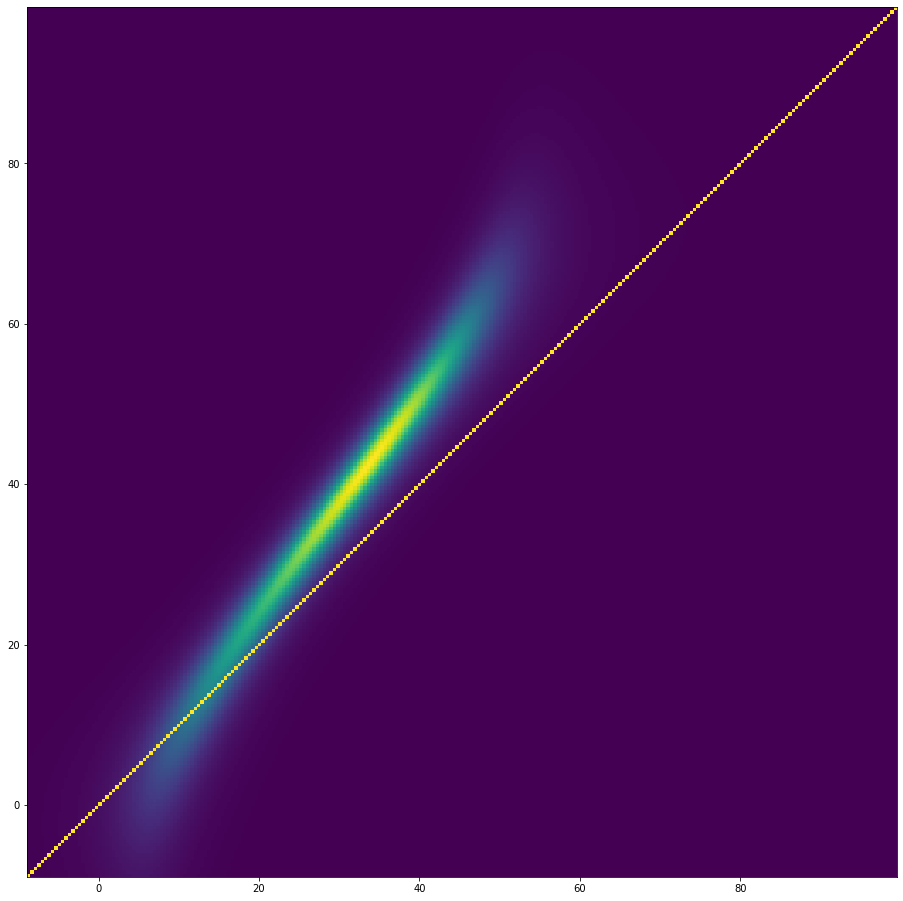

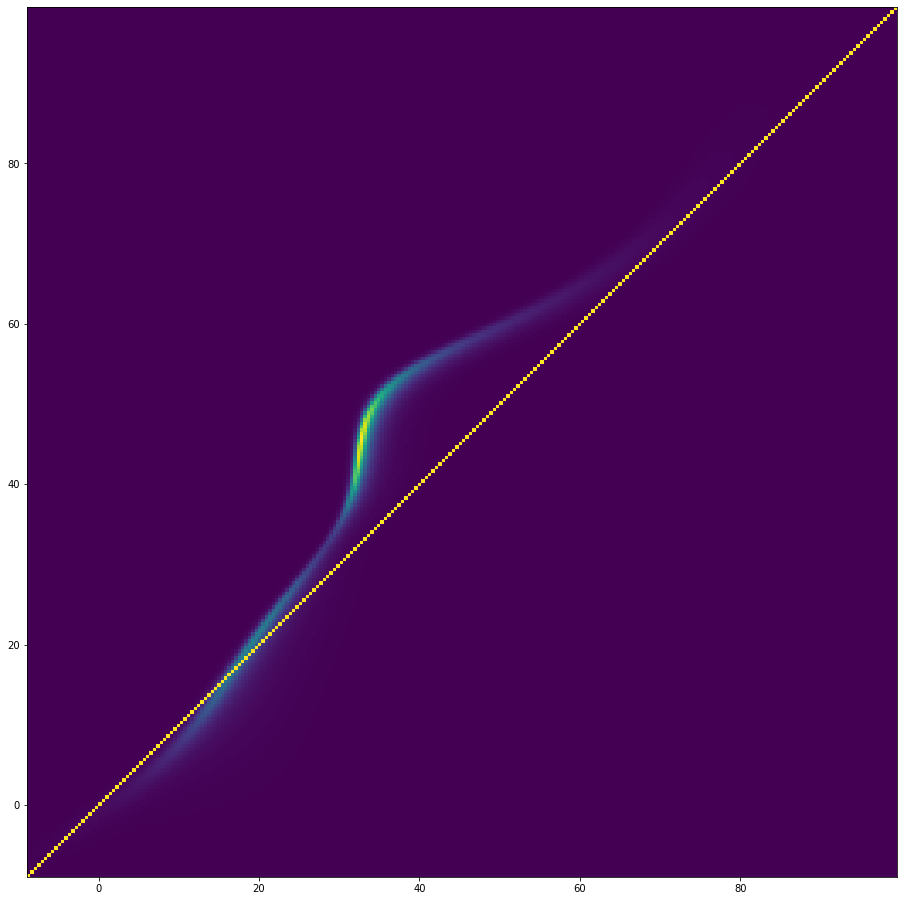

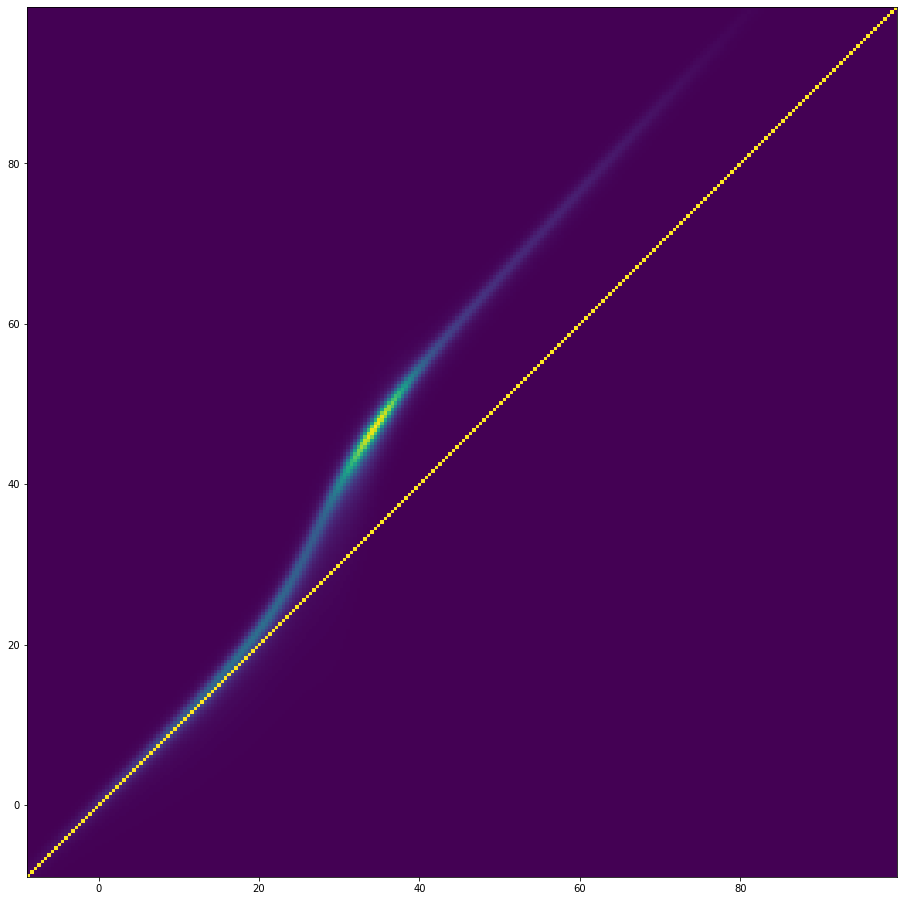

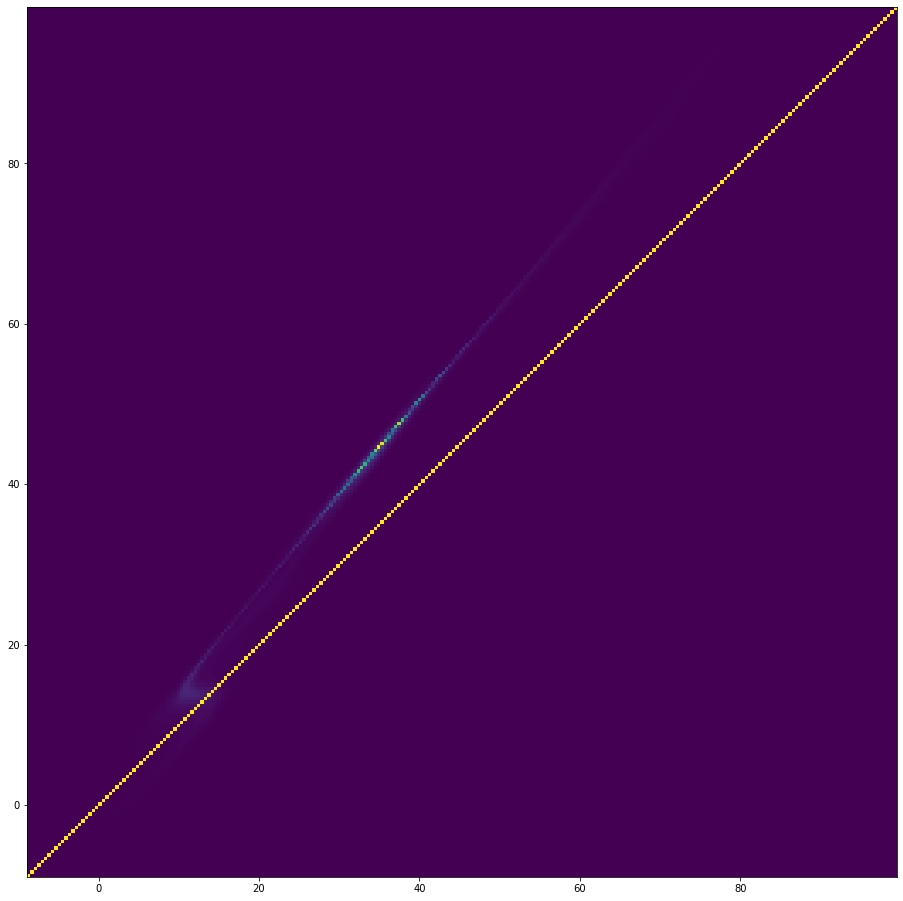

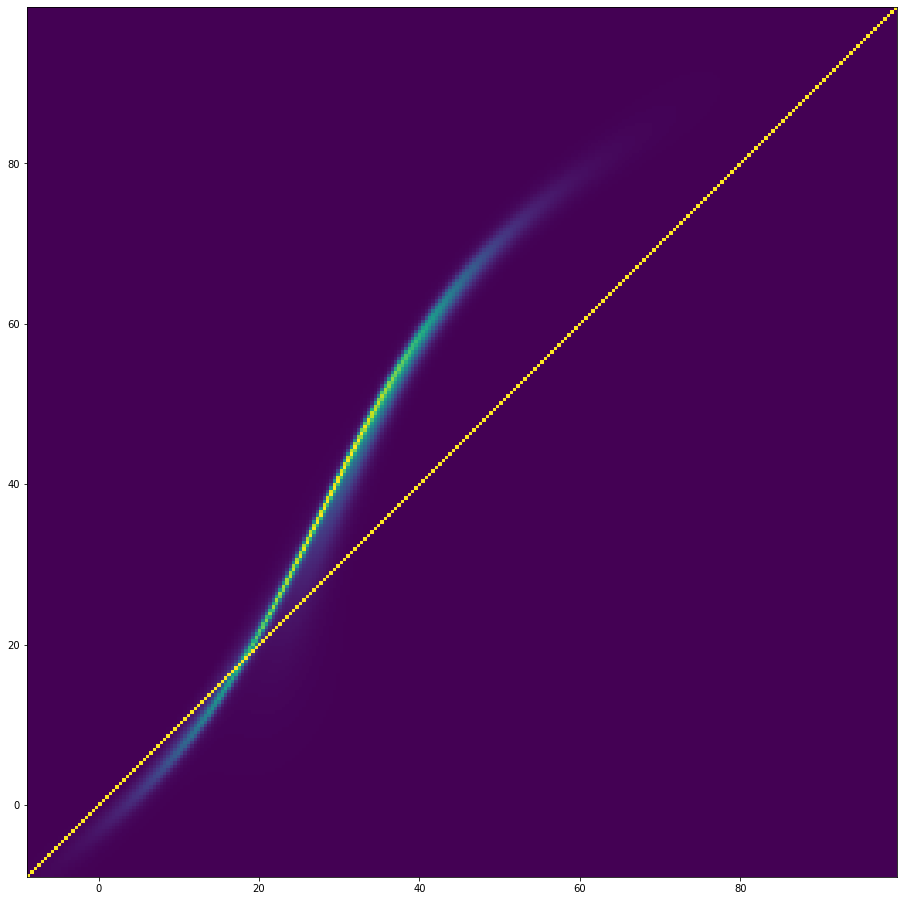

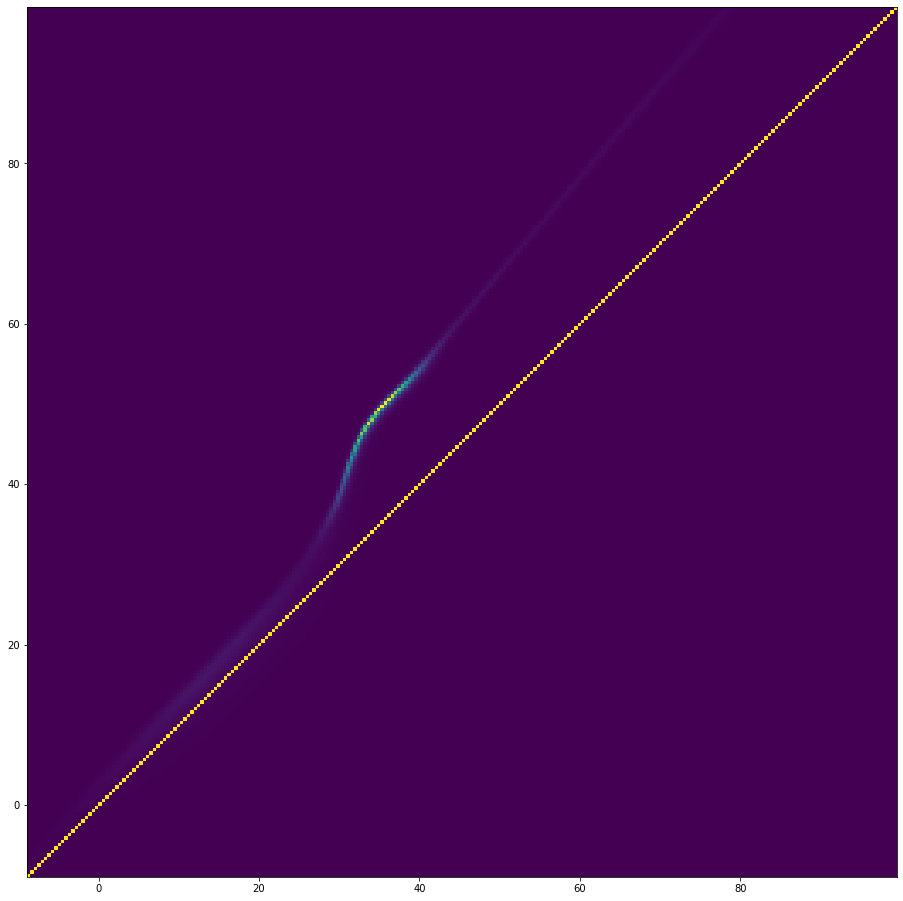

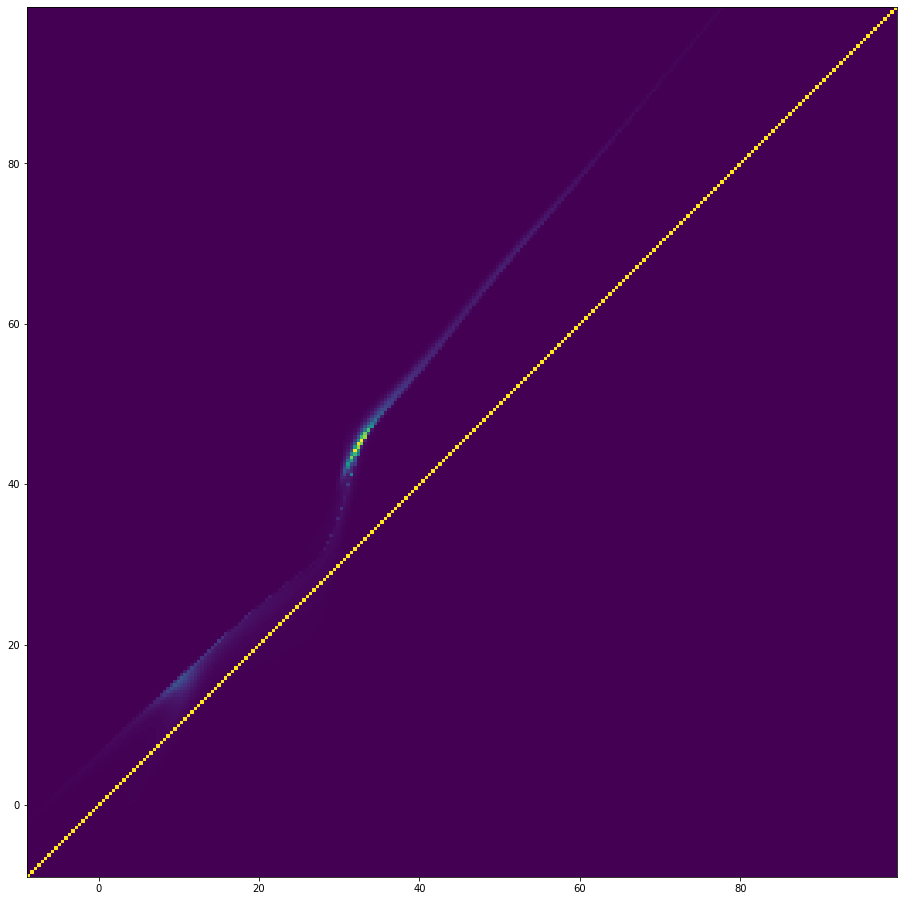

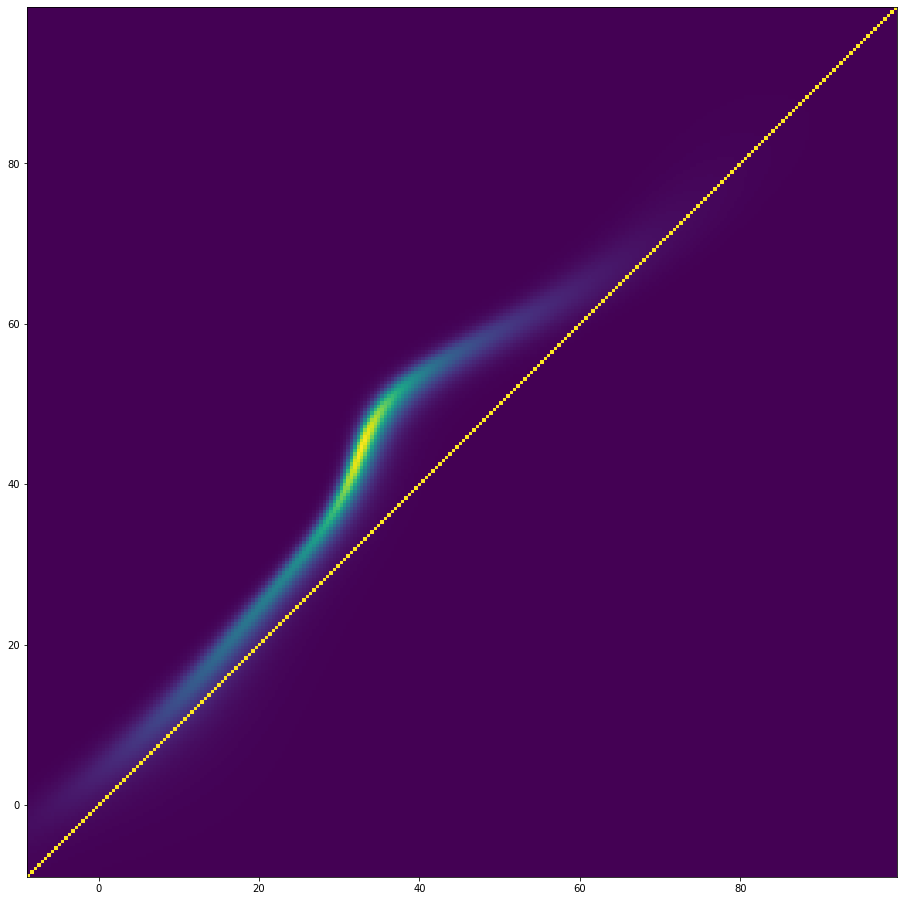

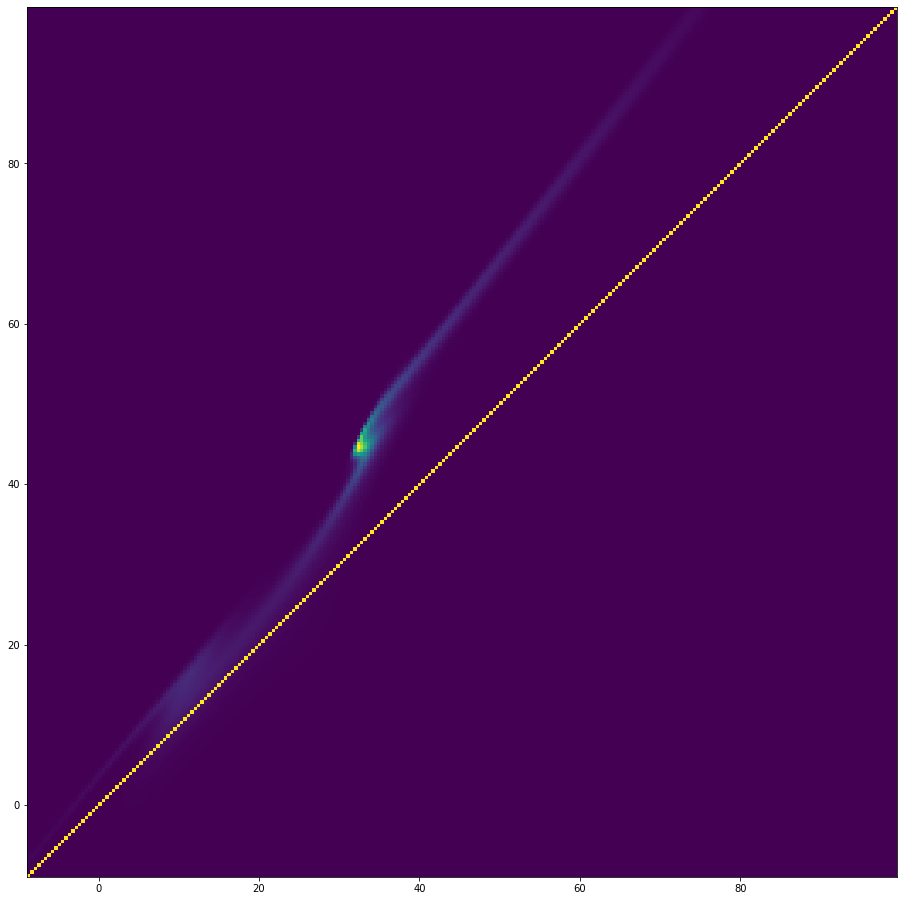

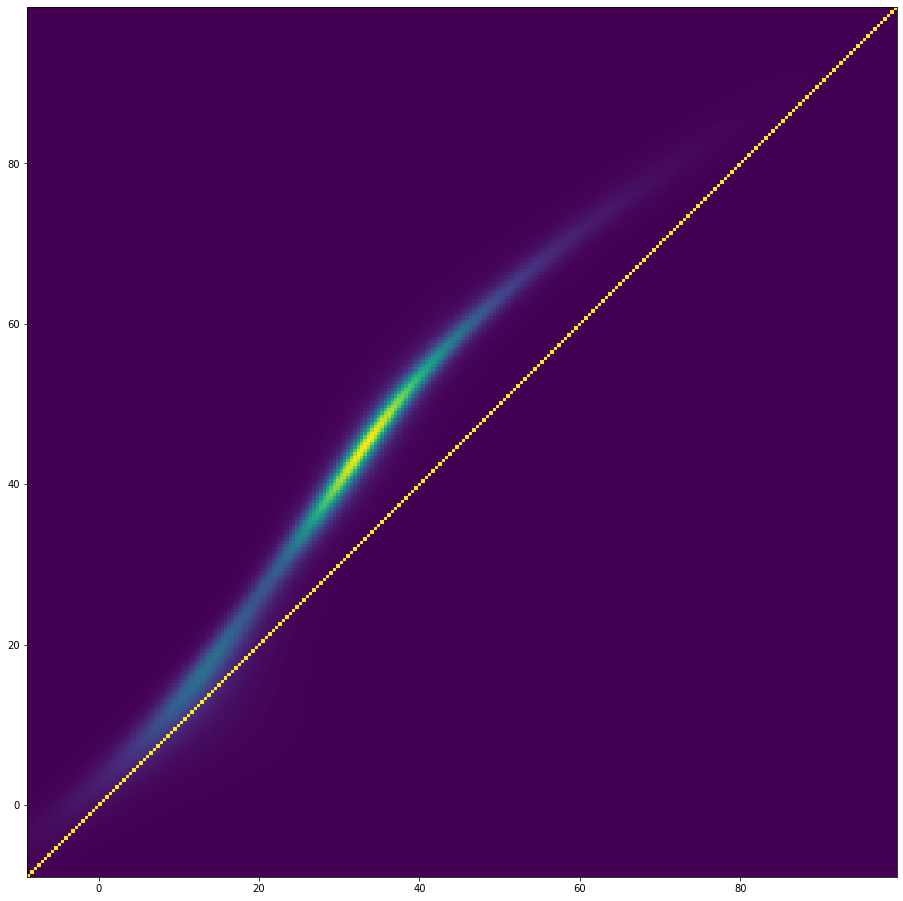

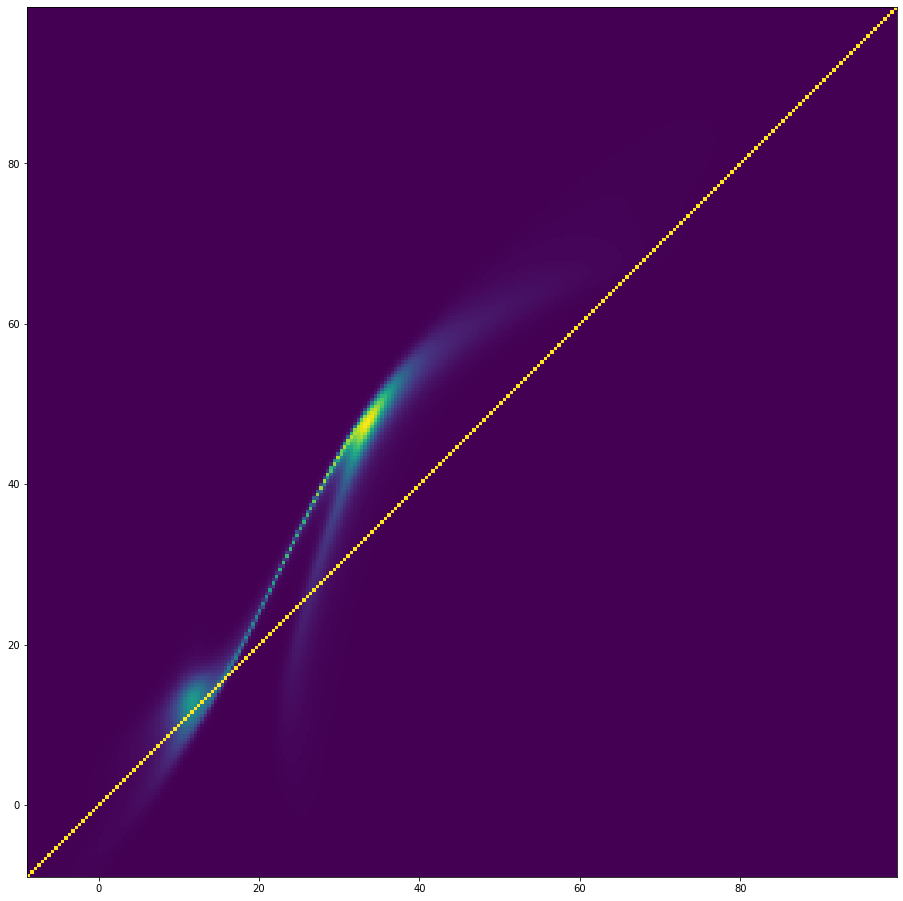

In [23]:
for i in range(len(probabilities['joint'])):
    plt.figure(figsize=(16, 16))
    p = probabilities['joint'][i]
    p[range(len(p)), range(len(p))] = p.max()
    plt.imshow(p, origin='lower', extent=(grid.min(), grid.max(), grid.min(), grid.max()x))
    plt.show()

<AxesSubplot:ylabel='Density'>

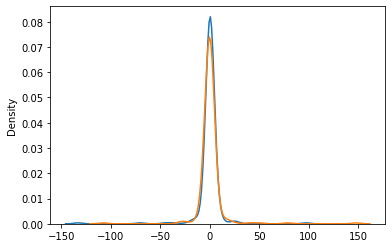

In [61]:
import numpy as np

x = np.random.rand(256) + 32

y = np.random.rand(256) * 2 + 30

z = x - y

import seaborn as sns

sns.kdeplot(((z - z.mean()) / z.std()) / ((x - x.mean()) / x.std()))

sns.kdeplot(((y - y.mean()) / y.std()) / ((x - x.mean()) / x.std()))



In [62]:
np.corrcoef(x, z)

array([[1.        , 0.43202263],
       [0.43202263, 1.        ]])

In [63]:
np.corrcoef(x, y)

array([[1.        , 0.02113931],
       [0.02113931, 1.        ]])